In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# """ EEGNet 的 Keras 实现
#      http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
#      请注意，这实现了最新版本的 EEGNet 而不是早期版本
#      版本（arxiv 上的版本 v1 和 v2）。 我们强烈推荐使用这个
#      体系结构，因为它比
#      我们的早期版本。 例如：
        
#          1. Depthwise Convolutions 学习空间过滤器
#          时间卷积。 depth_multiplier选项贴图的使用
#          精确到在一个时间段内学习的空间过滤器的数量
#          筛选。 这与 FBCSP 等学习算法的设置相匹配
#          滤波器组中每个滤波器内的空间滤波器。 这也限制了
#          与全连接相比，要适应的自由参数的数量
#          卷积。
        
#          2. Separable Convolutions 学习如何最佳结合空间
#          跨时间带的过滤器。 可分离卷积是深度的
#          卷积后跟 (1x1) 逐点卷积。
        
    
#      虽然原始论文使用了 Dropout，但我们发现 SpatialDropout2D
#      有时会为 ERP 分类产生更好的结果
#      信号。 然而，SpatialDropout2D 显着降低了性能
#      在振荡数据集（SMR，BCI-IV 数据集 2A）上。 我们推荐使用
#      大多数情况下默认的 Dropout。
        
#      假设输入信号以 128Hz 采样。 如果你想使用这个模型
#      对于任何其他采样率，您将需要修改时间长度
#      根据需要在块 1 和块 2 中添加内核和平均池化大小（加倍
#      内核长度加倍采样率等）。 请注意，我们没有
#      使用此规则测试了模型性能，因此这可能无法正常工作。
    
#      具有默认参数的模型给出了所讨论的 EEGNet-8,2 模型
#      在论文中。 总的来说，这个模型应该做得很好，尽管它是
# 建议进行一些模型搜索以获得最佳性能
# 特定的数据集。
#      我们设置 F2 = F1 * D（输入滤波器的数量 = 输出滤波器的数量）
#      SeparableConv2D 层。 我们还没有广泛测试这个的其他值
#      参数（例如，F2 < F1 * D 用于压缩学习，而 F2 > F1 * D 用于
#      过度完成）。 我们认为要关注的主要参数是 F1 和 D。
#      输入：
        
#        nb_classes : int，要分类的类数
#        Chans, Samples : 脑电图数据中的通道数和时间点
#        dropoutRate ：辍学分数
#        kernLength ：第一层时间卷积的长度。 我们发现
#                          将其设置为采样率的一半有效
#                          在实践中很好。 特别是对于 SMR 数据集
#                          因为数据在 4Hz 时是高通的，所以我们使用了一个内核
#                          长度为 32。
#        F1，F2：时间过滤器（F1）的数量和逐点的数量
#                过滤器 (F2) 学习。 默认值：F1 = 8，F2 = F1 * D。
#        D：每个时间段内要学习的空间过滤器的数量
#                          卷积。 默认值：D = 2
#        dropoutType ：SpatialDropout2D 或 Dropout，作为字符串传递。
#      """

In [3]:
# kernLength = 时间滤波核长度
# Chans =通道数，Samples =时间点数，F1 =时间滤波器数，D =深度乘法器(空间滤波器数)，F2 =点滤波器数，N =类数。
def EEGNet(nb_classes, Chans = 15, Samples = 256, 
             dropoutRate = 0.5, kernLength = 128, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
                         
    input1 = Input(shape = (Chans, Samples, 1))
    # time filter
    block1 = Conv2D(filters = F1, kernel_size = (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    # channel filter
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    # 降采样
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    # 分离卷积
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    # 分类卷积
    dense        = Dense(1, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    sigmoid      = Activation('sigmoid', name = 'sigmoid')(dense)
    
    return Model(inputs=input1, outputs=sigmoid)

In [4]:
# def EEGNet(nb_classes = 2, Chans = 17, Samples = 512, 
#              dropoutRate = 0.5, kernLength = 128, F1 = 8, 
#              D = 4, F2 = 32, norm_rate = 0.25, dropoutType = 'Dropout'):
    
#     if dropoutType == 'SpatialDropout2D':
#         dropoutType = SpatialDropout2D
#     elif dropoutType == 'Dropout':
#         dropoutType = Dropout
#     else:
#         raise ValueError('dropoutType must be one of SpatialDropout2D '
#                          'or Dropout, passed as a string.')
    
#     input1   = Input(shape = (Chans, Samples, 1))

#     ##################################################################
#     block1       = Conv2D(F1, (1, kernLength), padding = 'same',
#                                    input_shape = (Chans, Samples, 1),
#                                    use_bias = False)(input1)
#     block1       = BatchNormalization()(block1)
#     block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
#                                    depth_multiplier = D,
#                                    depthwise_constraint = max_norm(1.))(block1)
#     block1       = BatchNormalization()(block1)
#     block1       = Activation('elu')(block1)
#     block1       = AveragePooling2D((1, 4))(block1)
#     block1       = dropoutType(dropoutRate)(block1)
    
#     block2       = SeparableConv2D(F2, (1, 16),
#                                    use_bias = False, padding = 'same')(block1)
#     block2       = BatchNormalization()(block2)
#     block2       = Activation('elu')(block2)
#     block2       = AveragePooling2D((1, 8))(block2)
#     block2       = dropoutType(dropoutRate)(block2)
        
#     flatten      = Flatten(name = 'flatten')(block2)
    
#     dense        = Dense(nb_classes, name = 'dense', 
#                          kernel_constraint = max_norm(norm_rate))(flatten)
#     softmax      = Activation('softmax', name = 'softmax')(dense)
    
#     return Model(inputs=input1, outputs=softmax)

In [5]:
model = EEGNet(nb_classes=2,Chans=15,Samples=512,F1=8,D=4,F2=32)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 512, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 15, 512, 8)        1024      
                                                                 
 batch_normalization (BatchN  (None, 15, 512, 8)       32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 512, 32)       480       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 512, 32)       128       
 hNormalization)                                                 
                                                             

In [7]:
import mne
import glob
import xlrd
import numpy as np
import pandas as pd
import scipy.signal
import scipy.io as scio

from past.builtins import unicode

import warnings
warnings.filterwarnings("ignore")

In [8]:
#读取训练数据目录
train_data_file_path=sorted(glob.glob(r"../SE_train_processed/"+"*"))
print("训练集大小：",len(train_data_file_path))

#读取测试数据目录
test_data_file_path=sorted(glob.glob(r"../SE_test_processed/"+"*"))
print("测试集大小：",len(test_data_file_path))

训练集大小： 2060
测试集大小： 47


In [9]:
# 获取刺激参数
df_train = pd.read_excel("../SE_parameter/train_matched_stimulate_parameter.xlsx",engine='openpyxl')
df_test = pd.read_excel( "../SE_parameter/test_matched_stimulate_parameter.xlsx",engine='openpyxl')

In [10]:
# 构建训练和标签
y_train= df_train['result'].to_list()
print("训练集正样本比例：",sum(y_train)/len(y_train))

y_test = df_test['result'].to_list()
print("测试集正样本比例：",sum(y_test)/len(y_test))

训练集正样本比例： 0.4975728155339806
测试集正样本比例： 0.8936170212765957


In [11]:
raw = mne.io.read_raw_fif(train_data_file_path[0])
channel_num= len(raw.ch_names) # 选择的通道数
train_SE_len = 16 # 训练集的SE切片长度
test_SE_len = 16 # 测试集的SE切片长度
## 切成2s一段,标签拉长
y_train=[i for i in y_train for j in range(train_SE_len//2)]
y_test=[i for i in y_test for j in range(test_SE_len//2)]
print('训练集标签长度:',len(y_train))
print('测试集标签长度:',len(y_test))

Opening raw data file ../SE_train_processed\AV-严聪慧-20220803(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
训练集标签长度: 16480
测试集标签长度: 376


In [12]:
# 训练集数据读取
samps = 2
x_train=[]
for i in train_data_file_path:
    raw = mne.io.read_raw_fif(i)
    data,time=raw[:]
    for j in range(0,train_SE_len,samps):
        data_temp = []
        for k in range (channel_num):
            data_temp.append(data[k][j*256:(j+samps)*256])         
        x_train.append(data_temp)   

Opening raw data file ../SE_train_processed\AV-严聪慧-20220803(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-严聪慧-20220803(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-严聪慧-20220803(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-严聪慧-20220803(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-严聪慧-20220803(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-严聪慧-20220803random_flip_1.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-严聪慧-20220803

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-严聪慧-20220805random_flip_11.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-严聪慧-20220805random_flip_12.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-严聪慧-20220805random_flip_13.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-严聪慧-20220805random_flip_14.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-严聪慧-20220805random_flip_15.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-严聪慧-20220805random_flip_16.fif...
Isotrak not found
    Range : 0 ..

Ready.
Opening raw data file ../SE_train_processed\AV-何晓丽-20220824(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-何晓丽-20220824(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-何晓丽-20220826(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-何晓丽-20220826(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-何晓丽-20220826(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-何晓丽-20220826(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-何晓丽-20

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-余琛宇-20220422(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-余琛宇-20220422(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-余琛宇-20220422(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-余琛宇-20220422(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-倪泽菁-20220826(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-倪泽菁-20220826(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.

Ready.
Opening raw data file ../SE_train_processed\AV-刘汉悦-20220615(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-刘汉悦-20220615(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-刘汉悦-20220617(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-刘汉悦-20220617(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-刘汉悦-20220617(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-刘汉悦-20220617(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-刘汉悦-20

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-南添仁-20220511(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-南添仁-20220511(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-南添仁-20220511(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-南添仁-20220511(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-南添仁-20220513(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-南添仁-20220513(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-吴华丽-20220805random_flip_30.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-吴华丽-20220805random_flip_31.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-吴华丽-20220805random_flip_32.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-吴华丽-20220805random_flip_33.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-吴华丽-20220805random_flip_34.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-吴华丽-20220805random_flip_35.fif...
Isotrak not found
    Range : 0 ..

    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-吴华丽-20220808random_flip_36.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-吴华丽-20220808random_flip_37.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-吴华丽-20220808random_flip_38.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-吴华丽-20220808random_flip_39.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-吴华丽-20220808random_flip_4.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-吴华丽-20220808random_flip_40.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-周博-20220408random_flip_24.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-周博-20220408random_flip_25.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-周博-20220408random_flip_26.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-周博-20220408random_flip_27.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-周博-20220408random_flip_28.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-周博-20220408random_flip_29.fif...
Isotrak not found
    Range : 0 ... 4095

Ready.
Opening raw data file ../SE_train_processed\AV-周博-20220415random_flip_3.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-周博-20220415random_flip_30.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-周博-20220415random_flip_31.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-周博-20220415random_flip_32.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-周博-20220415random_flip_33.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-周博-20220415random_flip_34.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-唐心诚-20220905(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-唐心诚-20220905(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-唐心诚-20220905(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-唐心诚-20220905(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-唐心诚-20220905(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-夏帆-20220914(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-夏帆-20220923random_flip_34.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-夏帆-20220923random_flip_35.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-夏帆-20220923random_flip_36.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-夏帆-20220923random_flip_37.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-夏帆-20220923random_flip_38.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-夏帆-20220923random_flip_39.fif...
Isotrak not found
    Range : 0 ... 4095

    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-张君莉-20220615(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-彭国芬-20220812(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-彭国芬-20220812(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-彭国芬-20220812(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-彭国芬-20220812(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-彭国芬-20220812(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.


Ready.
Opening raw data file ../SE_train_processed\AV-彭国芬-20220815random_flip_1.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-彭国芬-20220815random_flip_10.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-彭国芬-20220815random_flip_11.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-彭国芬-20220815random_flip_12.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-彭国芬-20220815random_flip_13.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-彭国芬-20220815random_flip_14.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-徐洋忠-20220713(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-徐洋忠-20220713(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-徐洋忠-20220713(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-徐洋忠-20220715(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-徐洋忠-20220715(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-徐洋忠-20220715(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    1

Ready.
Opening raw data file ../SE_train_processed\AV-徐洋忠-20220718(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-徐洋忠-20220718(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-徐洋忠-20220720(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-徐洋忠-20220720(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-徐洋忠-20220720(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-徐洋忠-20220720(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-徐洋忠-20

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-成思思-20220805(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-成思思-20220805(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-成思思-20220805(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-成思思-20220805(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-成思思-20220805(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-成思思-20220808(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.99

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-施佩玲-20220629random_flip_25.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-施佩玲-20220629random_flip_26.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-施佩玲-20220629random_flip_27.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-施佩玲-20220629random_flip_28.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-施佩玲-20220629random_flip_29.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-施佩玲-20220629random_flip_3.fif...
Isotrak not found
    Range : 0 ...

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-李义泽-20220708(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-李义泽-20220711(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-李义泽-20220711(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-李义泽-20220711(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-李义泽-20220711(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-李义泽-20220711(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    1

Ready.
Opening raw data file ../SE_train_processed\AV-李艳雪-20220518(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-李艳雪-20220518(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-李艳雪-20220518(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-李艳雪-20220518(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-李艳雪-20220520(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-李艳雪-20220520(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-李艳雪-202205

    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-李财坚-20220727(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-林子幸-20220411(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-林子幸-20220411(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-林子幸-20220411(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-林子幸-20220411(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-林子幸-20220411(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.


Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-樊茂-20220610(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-樊茂-20220610(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-樊茂-20220610(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-汪佳星-20220706(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-汪佳星-20220706(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-汪佳星-20220706(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.9

Ready.
Opening raw data file ../SE_train_processed\AV-汪佳星-20220708(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-汪佳星-20220708(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-汪佳星-20220711(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-汪佳星-20220711(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-汪佳星-20220711(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-汪佳星-20220711(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-汪佳星-20

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王敏敏-20220826(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王敏敏-20220826(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王敏敏-20220826(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王敏敏-20220826(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王敏敏-20220829(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王敏敏-20220829(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.

Ready.
Opening raw data file ../SE_train_processed\AV-王胜银-20200520(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王胜银-20200520(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王胜银-20200523(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王胜银-20200523(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王胜银-20200523(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王胜银-20200523(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王胜银-20

Ready.
Opening raw data file ../SE_train_processed\AV-王莹-20220422random_flip_32.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王莹-20220422random_flip_33.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王莹-20220422random_flip_34.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王莹-20220422random_flip_35.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王莹-20220422random_flip_36.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王莹-20220422random_flip_37.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王诗雯-20220722random_flip_39.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王诗雯-20220722random_flip_4.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王诗雯-20220722random_flip_40.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王诗雯-20220722random_flip_5.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王诗雯-20220722random_flip_6.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王诗雯-20220722random_flip_7.fif...
Isotrak not found
    Range : 0 ... 40

Ready.
Opening raw data file ../SE_train_processed\AV-王诗雯-20220727random_flip_4.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王诗雯-20220727random_flip_40.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王诗雯-20220727random_flip_5.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王诗雯-20220727random_flip_6.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王诗雯-20220727random_flip_7.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-王诗雯-20220727random_flip_8.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_trai

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-祁燕-20220413random_flip_5.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-祁燕-20220413random_flip_6.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-祁燕-20220413random_flip_7.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-祁燕-20220413random_flip_8.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-祁燕-20220413random_flip_9.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-祁燕-20220415(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000

Ready.
Opening raw data file ../SE_train_processed\AV-肖敏霞-20220829random_flip_16.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-肖敏霞-20220829random_flip_17.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-肖敏霞-20220829random_flip_18.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-肖敏霞-20220829random_flip_19.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-肖敏霞-20220829random_flip_2.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-肖敏霞-20220829random_flip_20.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-胡望先-20220701(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-胡望先-20220706(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-胡望先-20220706(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-胡望先-20220706(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-胡望先-20220706(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-胡望先-20220706(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    1

Ready.
Opening raw data file ../SE_train_processed\AV-胡杨-20220824random_flip_24.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-胡杨-20220824random_flip_25.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-胡杨-20220824random_flip_26.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-胡杨-20220824random_flip_27.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-胡杨-20220824random_flip_28.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-胡杨-20220824random_flip_29.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-董沁鑫-20220711random_flip_30.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-董沁鑫-20220711random_flip_31.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-董沁鑫-20220711random_flip_32.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-董沁鑫-20220711random_flip_33.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-董沁鑫-20220711random_flip_34.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-董沁鑫-20220711random_flip_35.fif...
Isotrak not found
    Range : 0 ..

    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-裴瑞婷-20220420(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-裴瑞婷-20220420(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-裴瑞婷-20220420(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-裴瑞婷-20220420(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-裴瑞婷-20220420(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-裴瑞婷-20220422(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Open

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-邵子健-20220516(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-邵子健-20220516(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-邵子健-20220518(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-邵子健-20220518(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-邵子健-20220518(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-邵子健-20220518(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...   

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-陈琳-20220516(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-陈琳-20220516(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-陈琳-20220516(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-陈琳-20220516(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-陈琳-20220518(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-陈琳-20220518(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 se

Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220708random_flip_21.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220708random_flip_22.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220708random_flip_23.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220708random_flip_24.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220708random_flip_25.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220708random_flip_26.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220711random_flip_28.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220711random_flip_29.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220711random_flip_3.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220711random_flip_30.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220711random_flip_31.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220711random_flip_32.fif...
Isotrak not found
    Range : 0 ... 4095 

Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220713random_flip_33.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220713random_flip_34.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220713random_flip_35.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220713random_flip_36.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220713random_flip_37.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-雷磊-20220713random_flip_38.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train

Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-龚晓宇-20220622(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-龚晓宇-20220624(flip).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-龚晓宇-20220624(jitter).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-龚晓宇-20220624(original).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-龚晓宇-20220624(scale_down).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_train_processed\AV-龚晓宇-20220624(scale_up).fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    1

In [13]:
# 测试集数据读入
x_test=[]
for i in test_data_file_path:
    raw = mne.io.read_raw_fif(i)
    data,time=raw[:]
    for j in range(0,test_SE_len,samps):
        data_temp = []
        for k in range (channel_num):
            data_temp.append(data[k][j*256:(j+samps)*256])         
        x_test.append(data_temp)
x_test=np.array(x_test)
print(x_test.shape)

Opening raw data file ../SE_test_processed\AV-习俊豪-20220525.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_test_processed\AV-习俊豪-20220530.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_test_processed\AV-习俊豪-20220606.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_test_processed\AV-付宇欣-20220715.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_test_processed\AV-付宇欣-20220718.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_test_processed\AV-付宇欣-20220720.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ...    15.996 secs
Ready.
Opening raw data file ../SE_test_processed\AV-付宇欣-20220722.fif...
Isotrak not found
    Range : 0 ... 4095 =      0.000 ... 

In [14]:
x_train = np.array(x_train,dtype = np.float32)
y_train = np.array(y_train,dtype = np.float32)
x_test = np.array(x_test,dtype = np.float32)
y_test = np.array(y_test,dtype = np.float32)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(16480, 15, 512) (16480,)
(376, 15, 512) (376,)


In [15]:
from tensorflow.keras.optimizers import Adam
adam = Adam(lr=10e-5)
model.compile(loss='mse',  # 损失均方误差
              optimizer=adam,  # 优化器
              metrics='accuracy'
             )

In [32]:
#方便命名模型EEGnet
my_epochs = 70
my_batch_size=64
# 训练集的10%用作验证集
# my_validation_split=0.1
history = model.fit(x_train, y_train, 
                    batch_size = my_batch_size,
                    epochs = my_epochs,
                    verbose = 1
#                     validation_split = my_validation_split,
#                     shuffle=True
                   )

Epoch 1/5
129/129 [==============================] - 3s 19ms/step - loss: 0.1764 - accuracy: 0.7499
Epoch 2/5
129/129 [==============================] - 2s 18ms/step - loss: 0.1760 - accuracy: 0.7542
Epoch 3/5
129/129 [==============================] - 2s 18ms/step - loss: 0.1749 - accuracy: 0.7535
Epoch 4/5
129/129 [==============================] - 2s 18ms/step - loss: 0.1739 - accuracy: 0.7592
Epoch 5/5
129/129 [==============================] - 2s 18ms/step - loss: 0.1728 - accuracy: 0.7556


In [15]:
model = tf.keras.models.load_model('../model_save/EEGnet_70_64_0.7127_.h5')

In [16]:
# 查看测试集上的效果
test_result = model.evaluate(x_test,y_test)

12/12 [==============================] - 6s 4ms/step - loss: 0.1881 - accuracy: 0.7128


In [17]:
# 看一下输出的数值
pre_value=model.predict(x_test)
pre_value

12/12 [==============================] - 0s 4ms/step


array([[0.6687023 ],
       [0.30314982],
       [0.61255693],
       [0.60349786],
       [0.53616774],
       [0.8430699 ],
       [0.3559053 ],
       [0.54191774],
       [0.23091246],
       [0.7622385 ],
       [0.62878376],
       [0.71866244],
       [0.5600393 ],
       [0.4870113 ],
       [0.7874725 ],
       [0.8055717 ],
       [0.95435524],
       [0.7866853 ],
       [0.80971223],
       [0.74671656],
       [0.8196642 ],
       [0.39929408],
       [0.59773713],
       [0.6211821 ],
       [0.44906098],
       [0.7153232 ],
       [0.7126773 ],
       [0.92228156],
       [0.7375565 ],
       [0.94808495],
       [0.7892184 ],
       [0.51210576],
       [0.34763947],
       [0.72638565],
       [0.77985495],
       [0.6465967 ],
       [0.41496685],
       [0.53410435],
       [0.79455185],
       [0.47948048],
       [0.68721396],
       [0.6697937 ],
       [0.73663163],
       [0.5905851 ],
       [0.50553733],
       [0.6774822 ],
       [0.7960627 ],
       [0.660

In [18]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,confusion_matrix
y_pre = []
for i in pre_value:
    if i>0.5:
        y_pre.append(1)
    else:
        y_pre.append(0)

# 计算各个指标
accuracy = accuracy_score(y_test,y_pre)
precision = precision_score(y_test,y_pre)
recall = recall_score(y_test,y_pre)
F1_socre = f1_score(y_test,y_pre)
print(F1_socre,precision,recall,accuracy)

# 计算混淆矩阵
'''
标签\预测    0       1 
    0    0预测为0 0预测为1
    1    1预测为0 1预测为1
'''
confusion_matrix(y_test,y_pre)

0.8252427184466019 0.9042553191489362 0.7589285714285714 0.7127659574468085


array([[ 13,  27],
       [ 81, 255]], dtype=int64)

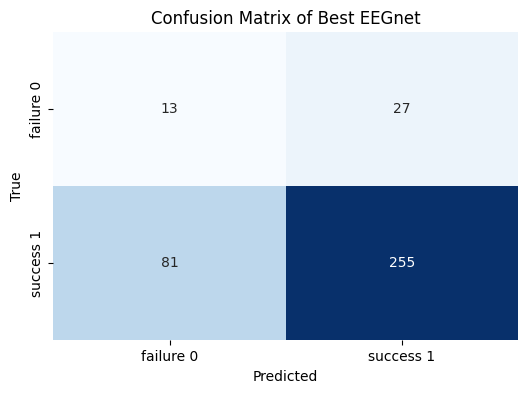

In [19]:
cm=confusion_matrix(y_test,y_pre)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['failure 0', 'success 1'], yticklabels=['failure 0', 'success 1'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of Best EEGnet")
plt.savefig("../img/best_EEGnet_conf"+".jpg")
# plt.savefig("../img/EEGnetconf_"+'50'+'_'+str(my_batch_size)+'_'+str(test_result[1])[:6]+".jpg")
plt.show()

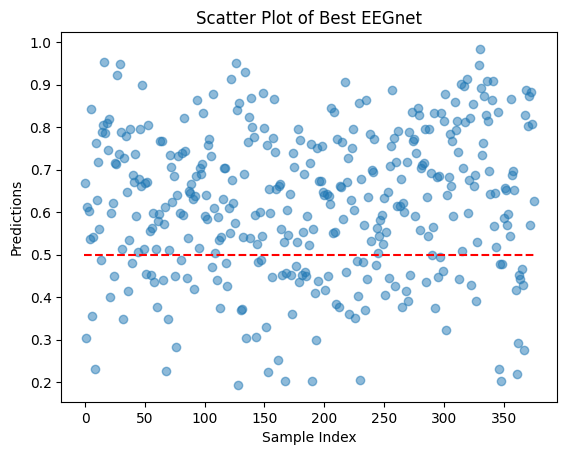

In [20]:
# 假设以下数据为模型预测输出和真实标签

# 绘制散点图
plt.scatter(range(len(pre_value)), pre_value, alpha=0.5)
plt.xlabel("Sample Index")
plt.ylabel("Predictions")

# 为了更好地展示数据分布，可以添加一个对角线
plt.plot([-1,len(pre_value)], [0.5, 0.5], linestyle="--", color="red")
plt.title("Scatter Plot of Best EEGnet")
plt.savefig("../img/best_EEGnet_pred"+".jpg")
# plt.savefig("../img/EEGnet_"+'90'+'_'+str(my_batch_size)+'_'+str(test_result[1])[:6]+".jpg")

plt.show()

12/12 [==============================] - 3s 8ms/step


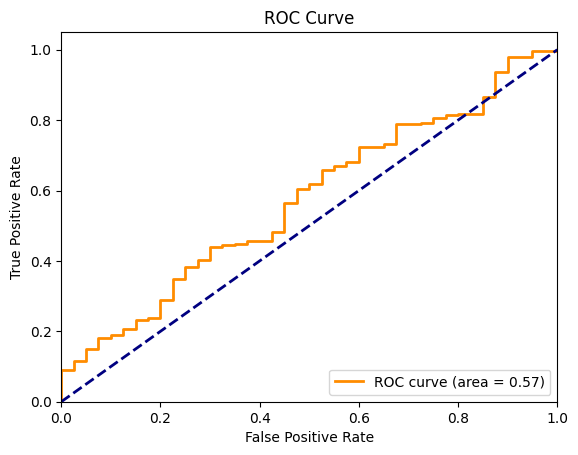

In [15]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('../model_save/EEGnet_70_64_0.7127_.h5')
pre_value=model.predict(x_test)
# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, pre_value)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [29]:
model.save('../model_save/EEGnet_'+'90'+ '_'+str(my_batch_size)+'_'+str(test_result[1])[:6] + "_.h5")

In [37]:
# acc = history.history['accuracy']
# val_acc=history.history['val_accuracy']
# loss = history.history['loss']
# val_loss=history.history['val_loss']
# epochs = range(1, len(acc) + 1)

# import matplotlib.pyplot as plt
# plt.title('acc and val_acc')
# plt.plot(epochs, acc, 'red', label='training acc')
# plt.plot(epochs, val_acc, 'blue', label='validation acc')
# plt.plot(epochs, loss, label='loss')
# plt.plot(epochs, val_loss, label='val_loss')
# plt.legend()#显示左上角的图例
# plt.savefig("./Image/EEGnet/acc_loss.jpg")
# plt.show()